In [14]:
.libPaths("C:/Program Files/R/R-3.3.0/library") # 라이브러리 설치 경로 설정


In [2]:
library(readxl)
library(ggplot2)
library(stringr)
library(dplyr)
library(tidyr)

glrvs <- guides(fill=guide_legend(reverse = TRUE), color=guide_legend(reverse = TRUE)) 

setwd("~/Project_timeSeriesAnalysis/data")

In [3]:
mungfile <- function(filename,date){ # date:string, "20160920"
        var_df <- read.csv(filename)
        # selDeleteLine = str_detect(var_df[,2], "[소총] 계")
        # var_df <- var_df[!selDeleteLine, ]
        # 9/22 MINOR MODIFICATION. REMOVED $DIST IN FUNCTION TO ACCOMODATE CONNMAX FILE. 
        # var_df$dist <- cut(var_df$TotPrbDLMax,breaks = seq(0,100, by=10),
        #                    labels = seq(10,100, by=10), include.lowest = TRUE)
        var_df$datetime <- str_c(date, var_df$time, sep=" ")
        var_df$datetime <- as.POSIXct(strptime(var_df$datetime,"%Y%m%d %H:%M", tz="GMT"))
        var_df$date <- date
        
        if(!is.null(var_df$CNUM))
                cellnum <- str_extract(var_df$CNUM, "\\d\\d?")
        if(!is.null(var_df$CELL_ID))
                cellnum <- str_extract(var_df$CELL_ID, "\\d\\d?")
        var_df$cellid <- str_c(var_df$eNB, cellnum, sep = "-")
        return(var_df)
}


# lfiles <- list.files(pattern = "prb5M\\d{8}")
# 
# for(file in lfiles){
#         fdate <- str_extract(file, "\\d{8}")
#         vdate <- str_sub(fdate,5)
#         assign(paste0("prb5M", vdate), mungfile(file,fdate))
# }

convCSV2dataframes <- function(pref, option="all"){ #prefix of filename...
        lfiles <- list.files(pattern = str_c(pref,"\\d{8}"))
        if(option=="add"){
                lfiles <- lfiles[length(lfiles)]
        }
        for(file in lfiles){
                fdate <- str_extract(file, "\\d{8}")
                vdate <- str_sub(fdate,5)
                assign(str_c(pref, vdate), mungfile(file,fdate), 
                       envir = .GlobalEnv)
        }
}


In [4]:
convCSV2dataframes("prb5M")
convCSV2dataframes("conn5M")
convCSV2dataframes("conn1H")
convCSV2dataframes("prb1H")


In [5]:
# get  time series of each cell on a matrix..

# tmp_df <-prb5M0919 %>% filter(FREQUENCY=="800MHz") %>% 
#         select(cellid, date, time, TotPrbDLMax) %>% arrange(cellid,date,time)
# 
# dim(tmp_df)


mkMTX <- function(df, Freq, value){
        value_index <-which(colnames(df)==value)
        #realName <- colnames(df)[value_index]
        colnames(df)[value_index] <- "value"
        tmp_df <- df %>% filter(FREQUENCY==Freq) %>% 
                select(cellid, date, time, value) %>% 
                arrange(cellid,date,time)
        
        mtx <- matrix(data=tmp_df$value,nrow=nrow(tmp_df)/12,ncol=12, byrow=TRUE)
        rownames(mtx) <- tmp_df$cellid[c(T,rep(F,11))]
        return(mtx)
}

mtx0919max <- mkMTX(prb5M0919, "800MHz", "TotPrbDLMax")
mtx0920max <- mkMTX(prb5M0920, "800MHz", "TotPrbDLMax")
mtx0921max <- mkMTX(prb5M0921, "800MHz", "TotPrbDLMax")

mtx0919avg <- mkMTX(prb5M0919, "800MHz", "TotPrbDLAvg")
mtx0920avg <- mkMTX(prb5M0920, "800MHz", "TotPrbDLAvg")
mtx0921avg <- mkMTX(prb5M0921, "800MHz", "TotPrbDLAvg")

maxoveravg <- mtx0919max/mtx0919avg

# plot(seq(5,60, by=5),mtx0919max[1,],type="l")
# plot(mtx0919max[,])


# make a 3-d array: cellid, time, date: value...

arr_PDmax <- array(0, c(dim(mtx0919max)[1], 12, 5), 
                   dimnames = list(rownames(mtx0919max),NULL, NULL))

arr_PDmax[,,1] <- mtx0919max
arr_PDmax[,,2] <- mtx0920max
arr_PDmax[,,3] <- mtx0921max

arr_PDavg <- array(0, c(dim(mtx0919max)[1], 12, 5), 
                   dimnames = list(rownames(mtx0919avg),NULL, NULL))

arr_PDavg[,,1] <- mtx0919avg
arr_PDavg[,,2] <- mtx0920avg
arr_PDavg[,,3] <- mtx0921avg


1-17097-0,0,0,0,0,0,0,0,0,0,0,0,0
1-17097-1,99.81,96.06,94.76,97.14,96.06,97.26,37.30,99.37,98.19,26.71,62.55,89.87
1-17097-10,99.28,99.16,95.61,98.58,96.86,98.96,99.33,99.19,98.94,98.98,98.87,98.96
1-17097-11,97.11,42.22,97.87,79.17,98.25,97.70,98.78,98.32,71.51,91.57,89.37,99.05
1-17097-2,89.76,88.80,75.20,46.89,94.33,62.98,88.95,66.93,96.81,96.83,96.78,99.22
1-17097-9,0,0,0,0,0,0,0,0,0,0,0,0


1-17097-0  1-17097-1 1-17097-10 1-17097-11  1-17097-2  1-17097-9 
         0          9         12          9          8          0

1-17097-1 1-17097-10 1-17097-11  1-17097-2  1-17098-2  1-17098-9  1-17100-9 
         9         12          9          8          4          7          6 
 1-17101-0 1-17101-11  1-17101-2  1-17101-9  1-17104-0 1-17104-10  1-17104-2 
         8          6          4          5          8          8          5 
 1-17104-9  1-17107-0 1-17107-10 1-17107-11  1-17107-9  1-17109-0  1-17112-0 
         4         12          6          5          9          1          6 
 1-17112-9 1-17124-10  1-17124-2 1-17125-10 1-17127-11  1-17127-2  1-17128-0 
        11         10          8          7          7          4          8 
 1-17128-9  1-18484-2  1-18486-0 1-18486-10 1-18486-11  1-20229-1  1-20229-9 
         4          5          2          6          0          4          7 
1-20234-10  1-20234-2 1-20236-27 1-20238-11  1-20238-9  1-20243-9 1-20246-18 
         6         12          5          9          4          6          2 
 1-20247-0 1-20247-29  1-21622-9  1-21911-0  1-21911-2 1-22035-28  1-22261-9 
         2          4          4          6          6          1          3 
 1-22264-0 1-22264-10 1-22264-11  1-22265-0  1-22265-2  1-22267-0 1-22267-10 
         6          6          4          5          4          7          7 
 1-22845-1  1-22846-0 1-22846-10  1-22846-9 1-22847-10  1-22847-2 1-22850-11 
         7          5          7          5          3          4          2 
 1-22850-2  1-22851-1 1-24083-19  1-24083-9  1-24085-0 1-24085-10  1-24085-2 
         6          5         10          7         11          8          6 
 1-24703-1 1-24703-11  1-24703-2  1-24704-9 1-24715-10 1-24716-11  1-24716-2 
         5          1          6          3          2          3          3 
 1-24717-1 1-24717-11  1-24717-2  1-24718-2  1-25169-9 1-25412-11  1-25415-1 
         4         12          0          5          1         12          1 
 1-25415-2  1-25416-0 1-25417-10  1-25418-2  1-25419-9  1-25420-1 1-25420-10 
         1          8          4          8          3          8          9 
 1-25421-0  1-25421-2  1-25428-2 1-25430-11  1-25433-9 1-25434-11  1-25436-9 
         2          6          6          7          3          6          1 
 1-25437-1  1-25437-9  1-26499-0  1-26499-2 1-26499-29  1-26499-9  1-26500-2 
         2          3          6          4          7         12          8 
 1-26501-9  1-26503-0  1-26503-1  1-26505-9 1-26507-10  1-26507-9  1-26508-9 
         5          9         10          7          6          3          4 
 1-26509-0  1-26509-1 1-26511-10  1-26512-0  1-26512-2  1-26513-0  1-26513-1 
         4          7          6          8          7          7          9 
 1-26513-9 1-26514-10 1-26515-10  1-26515-9  1-26517-0 1-26518-11  1-26519-0 
         7          3          6          8          5         10          6 
 1-26519-2 1-26521-11  1-26538-0 1-26538-11  1-26538-2  1-26539-0  1-26539-2 
         5          3          5          9          6         10          5 
1-26540-11  1-26541-2 1-26544-29 1-26547-11  1-26575-1  1-27839-1  1-27839-9 
         8          9          6          5          3          1          6 
 1-29425-7  1-29425-8  1-29428-2  1-29431-1  1-29431-2  1-29431-5  1-29431-7 
         8          9         10          3          4          3          3 
 1-29432-2  1-29433-4  1-29433-5  1-29434-1  1-29434-8  1-29436-2  1-29436-4 
         5          2          9          8          4          6          6 
 1-29437-4 
         4

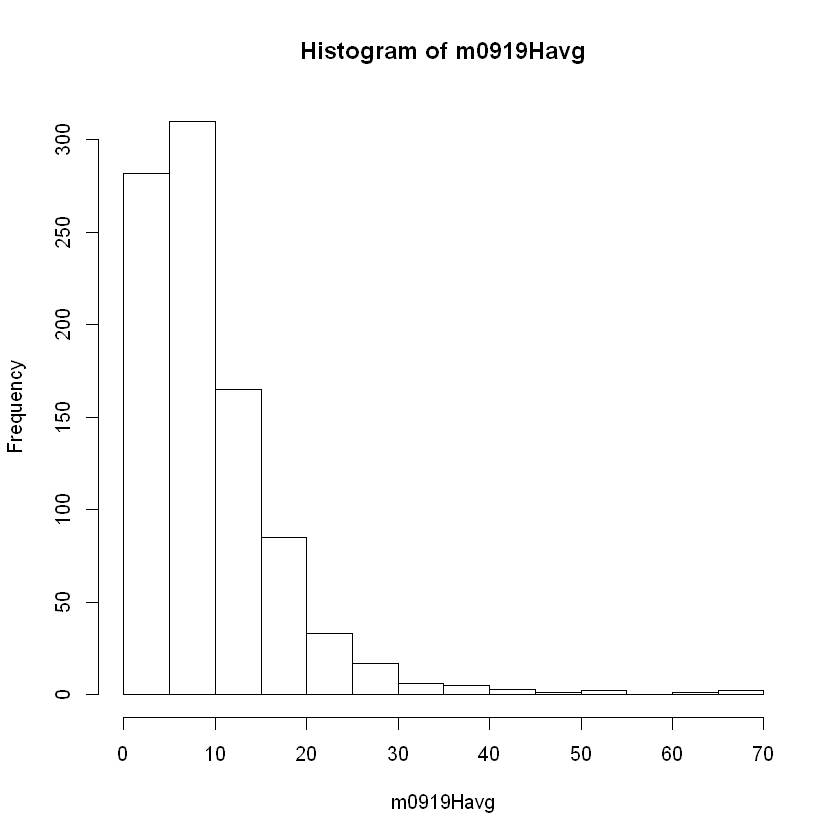

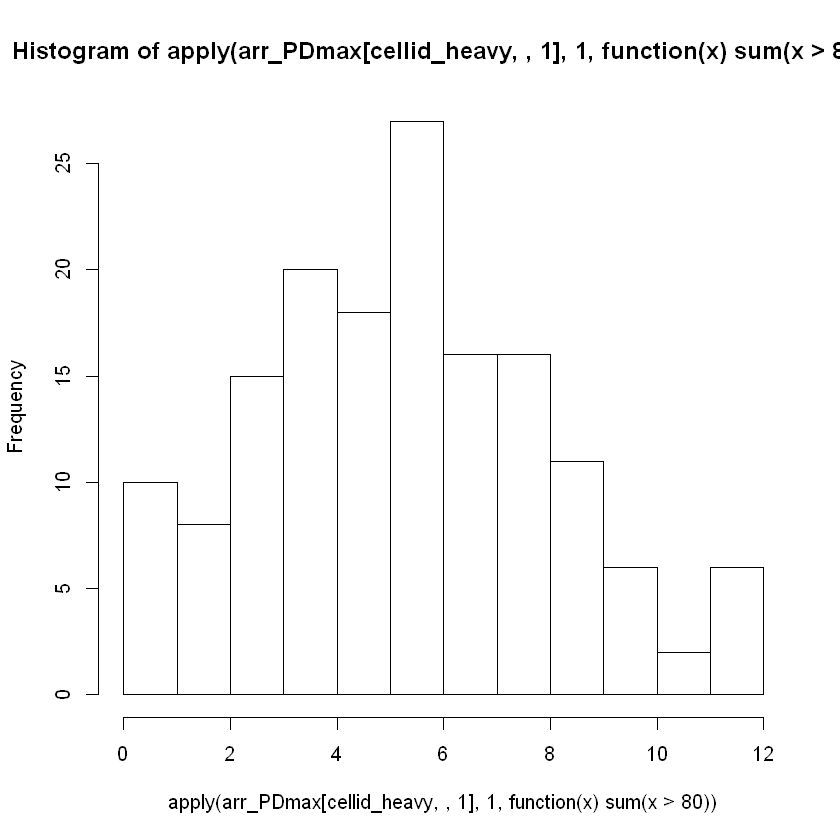

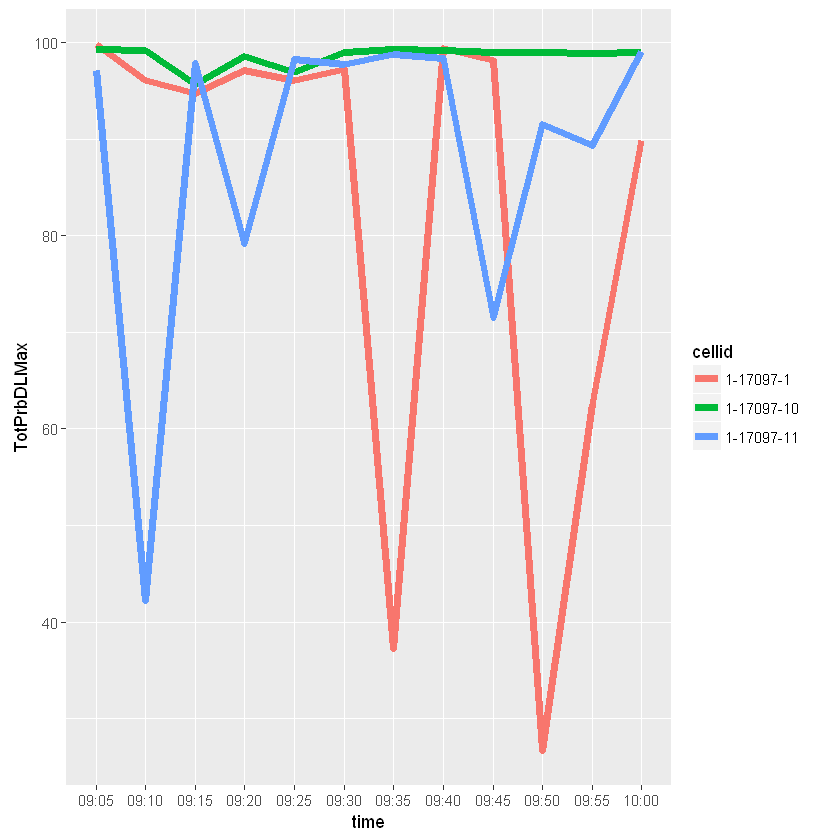

In [6]:
# Get Insight to select right samples...

head(arr_PDmax[,,1])
head(apply(arr_PDmax[,,1],1,function(x) sum(x > 80)))

m0919Havg <- apply(mtx0919avg, 1, mean)

hist(m0919Havg)

tmp_mtx <-m0919Havg[m0919Havg > 15]
cellid_heavy <- attr(tmp_mtx,"names")

apply(arr_PDmax[cellid_heavy,,1],1, function(x) sum(x > 80))
hist(apply(arr_PDmax[cellid_heavy,,1],1, function(x) sum(x > 80)))

ggplot(prb5M0919 %>% filter(cellid %in% cellid_heavy[1:3]),
       aes(time,TotPrbDLMax,color=cellid, group=cellid)) + geom_line(size=2) 



In [27]:
colnames(prb1HTot)

[1] "X"                     "complexinfo"           "FREQUENCY"            
 [4] "CNUM"                  "CellCount"             "TotPrbDLAvg"          
 [7] "TotPrbDLMin"           "TotPrbDLMax"           "TotPrbDLTot"          
[10] "TotPrbDLCnt"           "TotGbrPrbDLAvg"        "TotGbrPrbDLMin"       
[13] "TotGbrPrbDLMax"        "TotGbrPrbDLTot"        "TotGbrPrbDLCnt"       
[16] "TotNGbrPrbDLAvg"       "TotNGbrPrbDLMin"       "TotNGbrPrbDLMax"      
[19] "TotNGbrPrbDLTot"       "TotNGbrPrbDLCnt"       "TotPrbULAvg"          
[22] "TotPrbULMin"           "TotPrbULMax"           "TotPrbULTot"          
[25] "TotPrbULCnt"           "TotGbrPrbULAvg"        "TotGbrPrbULMin"       
[28] "TotGbrPrbULMax"        "TotGbrPrbULTot"        "TotGbrPrbULCnt"       
[31] "TotNGbrPrbULAvg"       "TotNGbrPrbULMin"       "TotNGbrPrbULMax"      
[34] "TotNGbrPrbULTot"       "TotNGbrPrbULCnt"       "TotPrbDLCurr"         
[37] "TotPrbULCurr"          "TotPucchPrbULAvg"      "TotUsedPucchPrbULNum" 
[40] "TotAvailPrbULNum"      "TotPucchPuschPrbULAvg" "TotUsedPuschPrbULNum" 
[43] "TotNgbrSCellPrbDLAvg"  "TotNgbrSCellPrbDLNum"  "TotAvailPrbDLNum"     
[46] "eNB"                   "time"                  "datetime"             
[49] "date"                  "cellid"

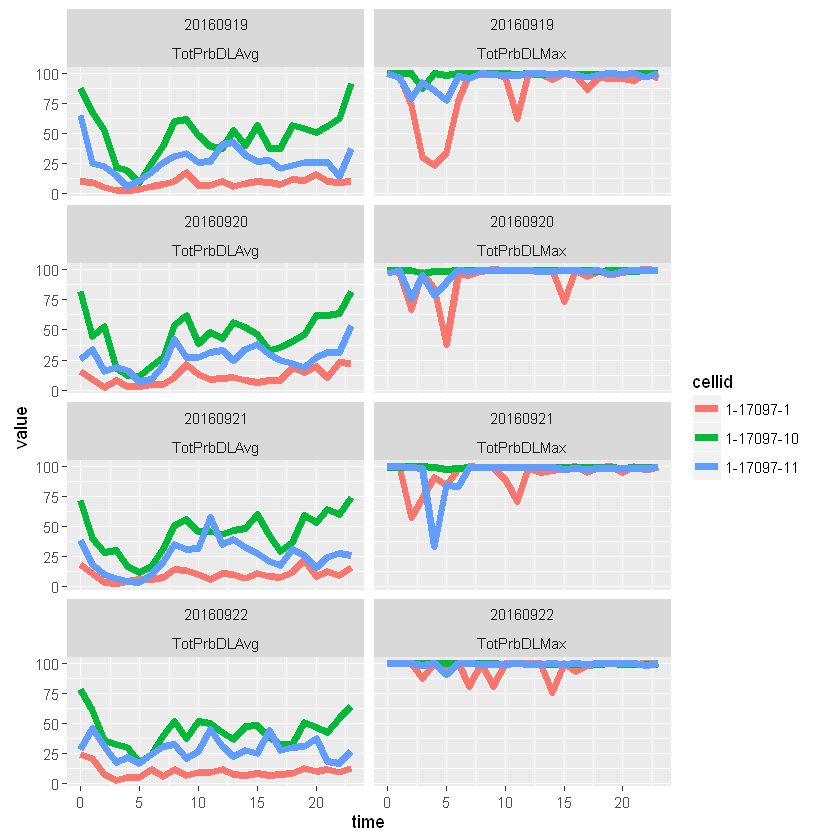

In [7]:
###############  hourly Trend 00:00 ~ 24:00 ########
###### PRB ########
varList <-ls(pattern = "prb1H\\d{4}$")
var_list <- lapply(varList, function(x) eval(parse(text = x)) )
prb1HTot <- do.call(rbind, var_list)

prb1HTot.gr <- gather(prb1HTot, "key", "value", c(6,8)) %>% 
        select(cellid, FREQUENCY, date, time, key, value)


ggplot(prb1HTot.gr %>% filter(cellid %in% cellid_heavy[1:3]),
       aes(time,value,color=cellid, group=cellid)) + geom_line(size=2) +
        facet_wrap(~date+key, ncol=2)


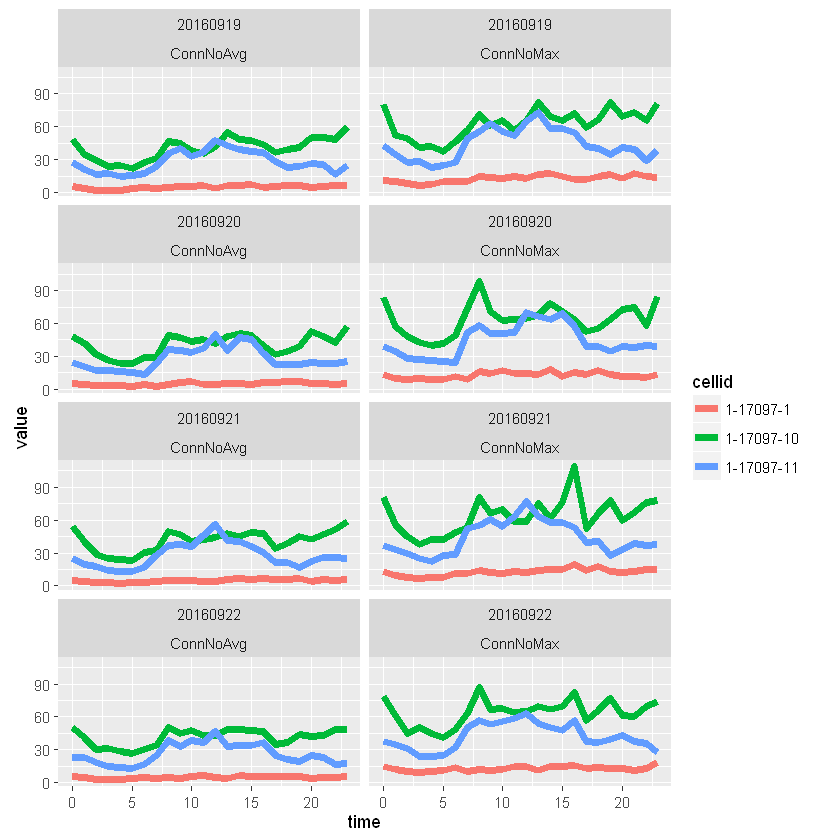

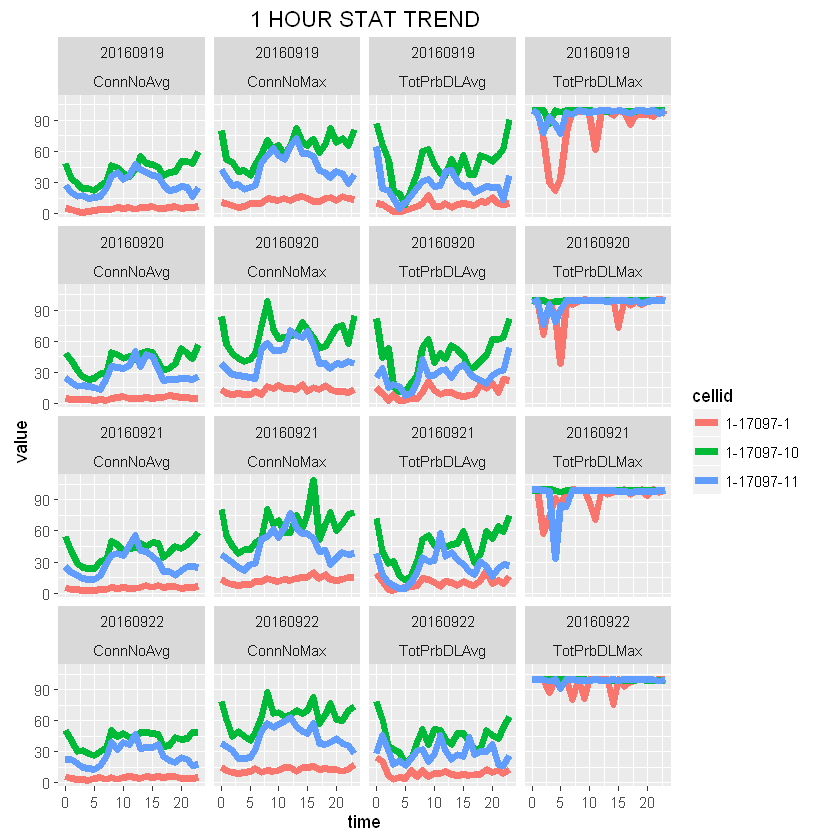

In [8]:
###### CONNMAX #####
varList <-ls(pattern = "conn1H\\d{4}$")
var_list <- lapply(varList, function(x) eval(parse(text = x)) )
conn1HTot <- do.call(rbind, var_list)

conn1HTot.gr <- gather(conn1HTot, "key", "value", c(5,6)) %>% 
                  select(cellid, FREQUENCY, date, time, key, value)


ggplot(conn1HTot.gr %>% filter(cellid %in% cellid_heavy[1:3]),
       aes(time,value,color=cellid, group=cellid)) + geom_line(size=2) +
        facet_wrap(~date+key, ncol=2)
####### combind result 
combind1H.gr <- rbind(prb1HTot.gr, conn1HTot.gr)
ggplot(combind1H.gr %>% filter(cellid %in% cellid_heavy[1:3]),
       aes(time,value,color=cellid, group=cellid)) + geom_line(size=2) +
        facet_wrap(~date+key, ncol=4) + ggtitle("1 HOUR STAT TREND")

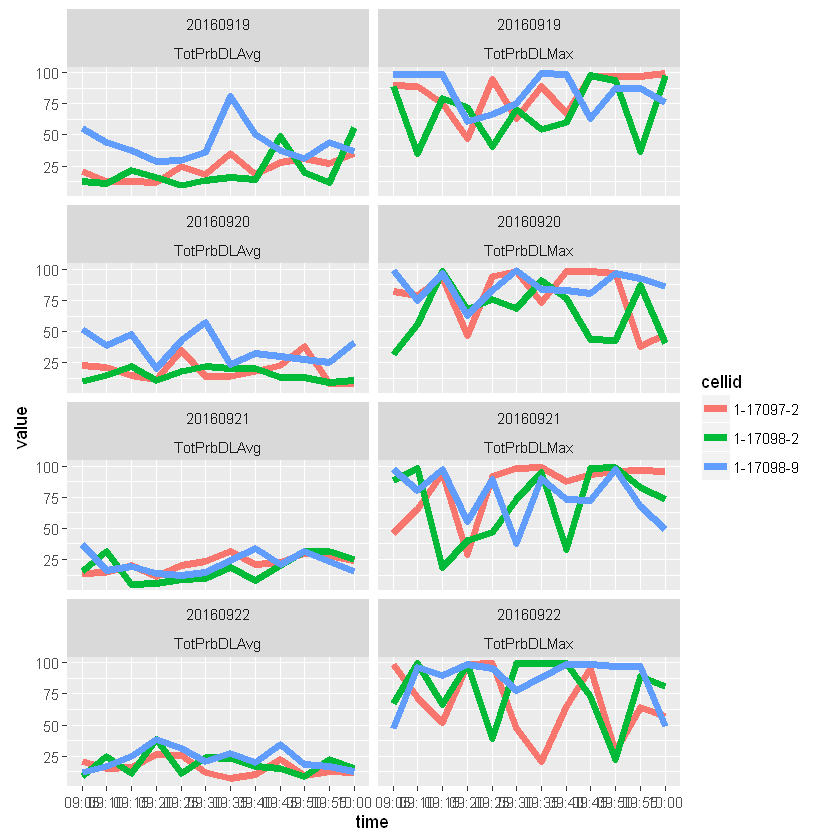

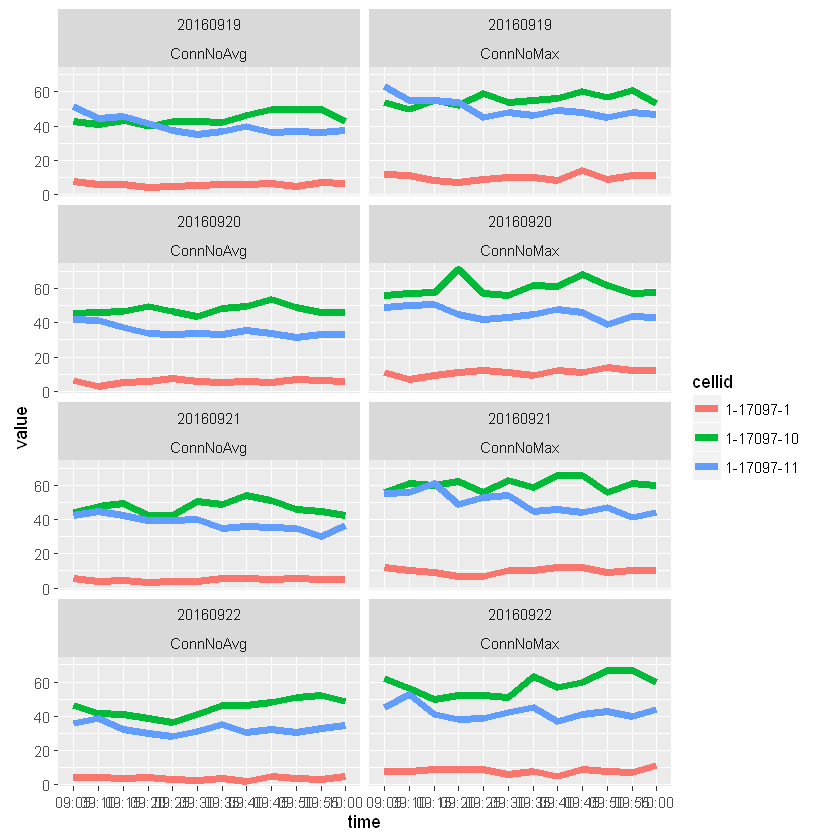

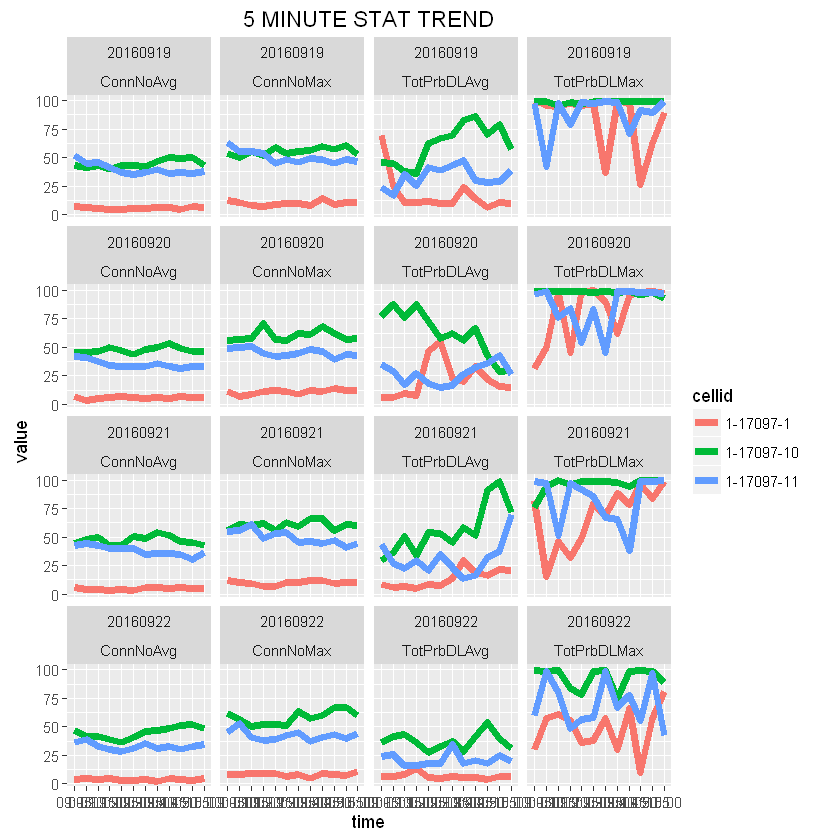

In [9]:
################ 5 Minute Data Trend in 9:00-10:00  #########
### PRB ########
varList <-ls(pattern = "prb5M\\d{4}$")
var_list <- lapply(varList, function(x) eval(parse(text = x)) )
prb5MTot <- do.call(rbind, var_list)
prb5MTot.gr <- gather(prb5MTot, "key", "value", c(6,8)) %>% 
        select(cellid, FREQUENCY, date, time, key, value)

ggplot(prb5MTot.gr %>% filter(cellid %in% cellid_heavy[4:6]),
       aes(time,value,color=cellid, group=cellid)) + geom_line(size=2) +
        facet_wrap(~date+key, ncol=2)
######## CONNMAX ##########
varList <-ls(pattern = "conn5M\\d{4}$")
var_list <- lapply(varList, function(x) eval(parse(text = x)) )
conn5MTot <- do.call(rbind, var_list)

conn5MTot.gr <- gather(conn5MTot, "key", "value", c(5,6)) %>% 
        select(cellid, FREQUENCY, date, time, key, value)


ggplot(conn5MTot.gr %>% filter(cellid %in% cellid_heavy[1:3]),
       aes(time,value,color=cellid, group=cellid)) + geom_line(size=2) +
        facet_wrap(~date+key, ncol=2)
####### combind results
combind5M.gr <- rbind(prb5MTot.gr, conn5MTot.gr)
ggplot(combind5M.gr %>% filter(cellid %in% cellid_heavy[1:3]),
       aes(time,value,color=cellid, group=cellid)) + geom_line(size=2) +
        facet_wrap(~date+key, ncol=4) + ggtitle("5 MINUTE STAT TREND")


Warning message:
In plot.window(...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In plot.xy(xy, type, ...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In title(...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In plot.window(...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In plot.xy(xy, type, ...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In title(...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In axis(side = side, at = at, labels = labels, ...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In plot.window(...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In plot.xy(xy, type, ...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In title(...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In plot.window(...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In plot.xy(xy, type, ...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In title(...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In axis(side = side, at = at, labels = labels, ...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In axis(side = side, at = at, labels = labels, ...)

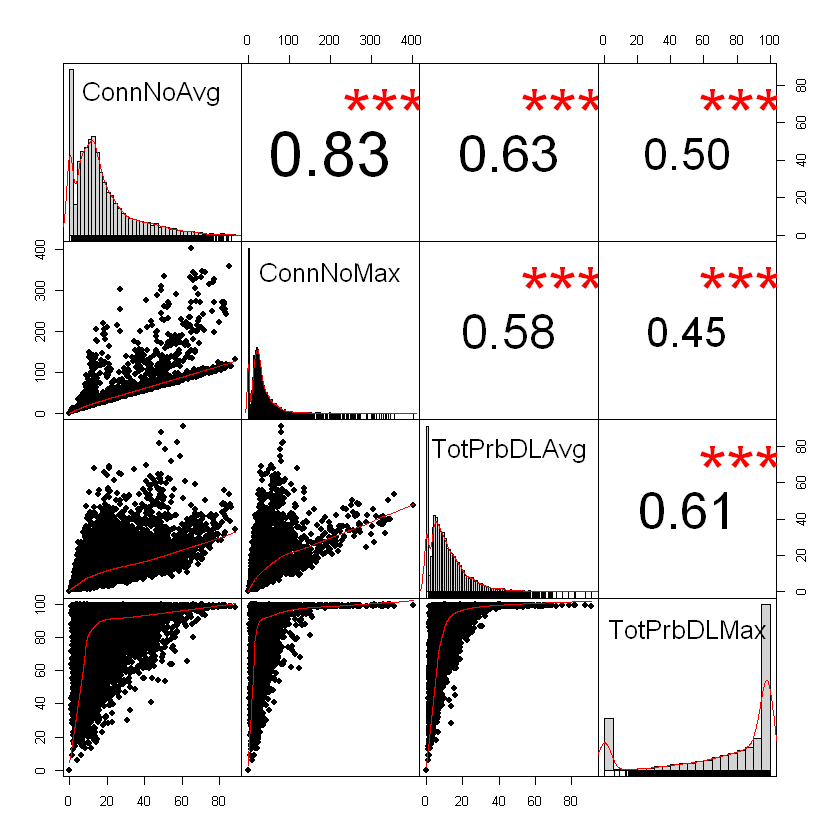

In [22]:
############
library(PerformanceAnalytics)

combind1H <- spread(combind1H.gr, key, value)

chart.Correlation(combind1H[1:10000,5:8], histogram=TRUE, pch=19)


In [20]:
head(combind1H)

,cellid,FREQUENCY,date,time,ConnNoAvg,ConnNoMax,TotPrbDLAvg,TotPrbDLMax
1,1-17097-0,800MHz,20160919,0,0,0,0,0
2,1-17097-0,800MHz,20160919,1,0,0,0,0
3,1-17097-0,800MHz,20160919,2,0,0,0,0
4,1-17097-0,800MHz,20160919,3,0,0,0,0
5,1-17097-0,800MHz,20160919,4,0,0,0,0
6,1-17097-0,800MHz,20160919,5,0,0,0,0


Warning message:
In plot.window(...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In plot.xy(xy, type, ...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In title(...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In plot.window(...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In plot.xy(xy, type, ...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In title(...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In axis(side = side, at = at, labels = labels, ...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In plot.window(...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In plot.xy(xy, type, ...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In title(...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In plot.window(...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In plot.xy(xy, type, ...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In title(...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In axis(side = side, at = at, labels = labels, ...): "method"는 그래픽 매개변수가 아닙니다Warning message:
In axis(side = side, at = at, labels = labels, ...)

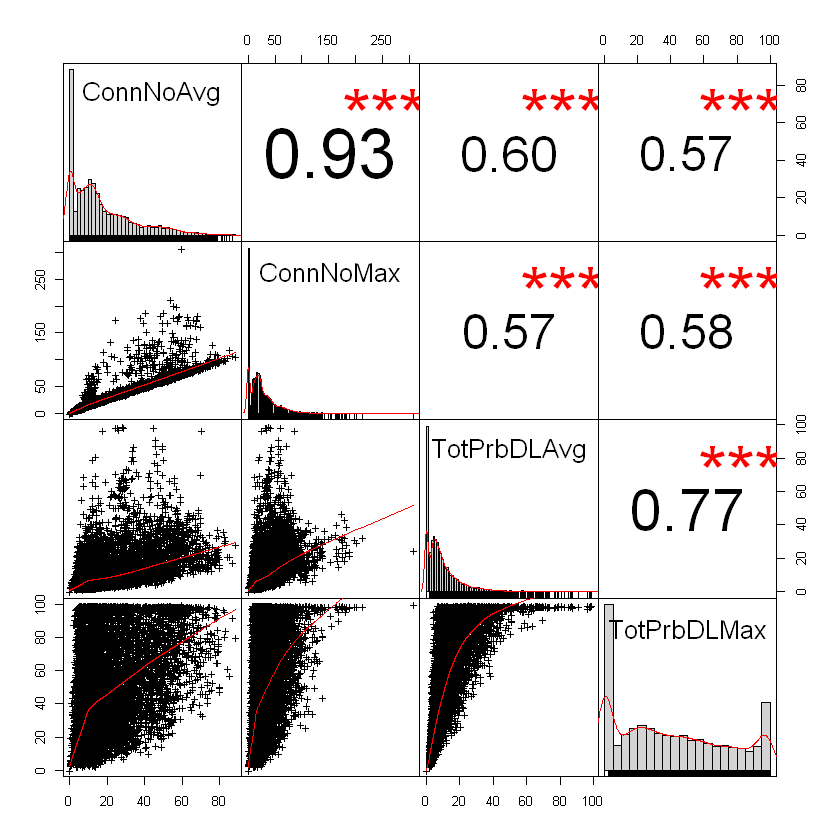

In [23]:
############
combind5M <- spread(combind5M.gr, key, value)

chart.Correlation(combind5M[1:10000,5:8], histogram=TRUE, pch="+")
#chart.Correlation(combind5M[10000:20000,5:8], histogram=TRUE, pch="+")
#chart.Correlation(combind5M[20000:30000,5:8], histogram=TRUE, pch="+")

#####
# find the characteristics which occurs daily...
# and some difference could be distinguished 



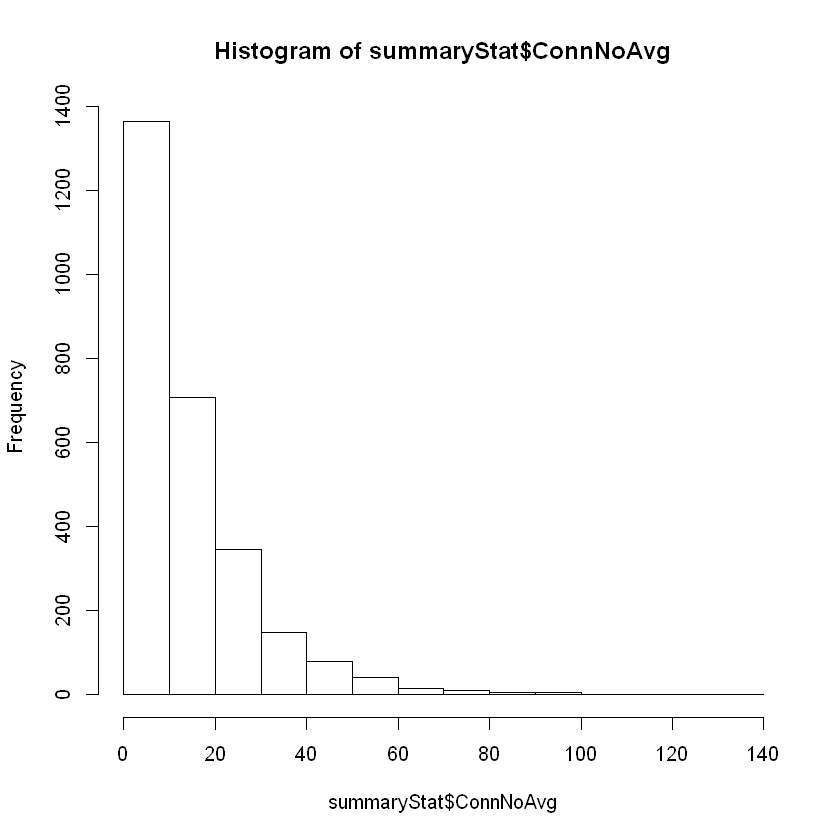

In [24]:

# consider qcc algorithm...

##################

summaryStat <- combind5M %>% group_by(cellid,FREQUENCY) %>% 
        summarise_each(funs(mean), matches("Avg"))

hist(summaryStat$ConnNoAvg)


CONN9 <- quantile(summaryStat$ConnNoAvg,probs = 0.9)  # high 10%  has get the value above 15.45
CONN8 <- quantile(summaryStat$ConnNoAvg,probs = 0.8)  # high 10%  has get the value above 15.45

groupCONN9 <- summaryStat %>% filter(ConnNoAvg > CONN9)
groupCONN8 <- summaryStat %>% filter(ConnNoAvg > CONN8 & ConnNoAvg <= CONN9 )


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


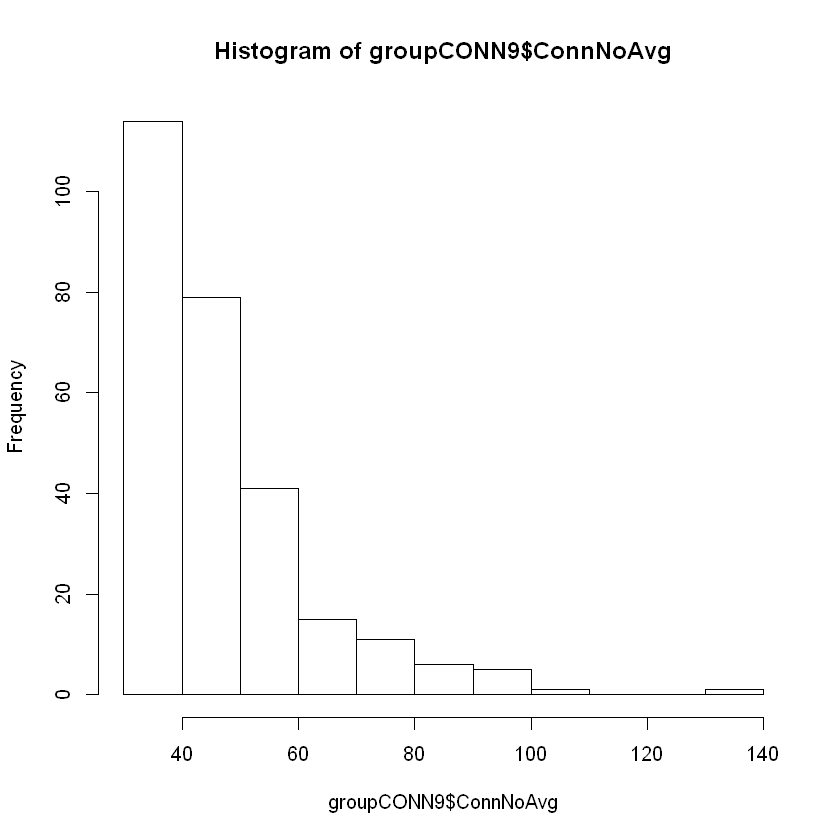

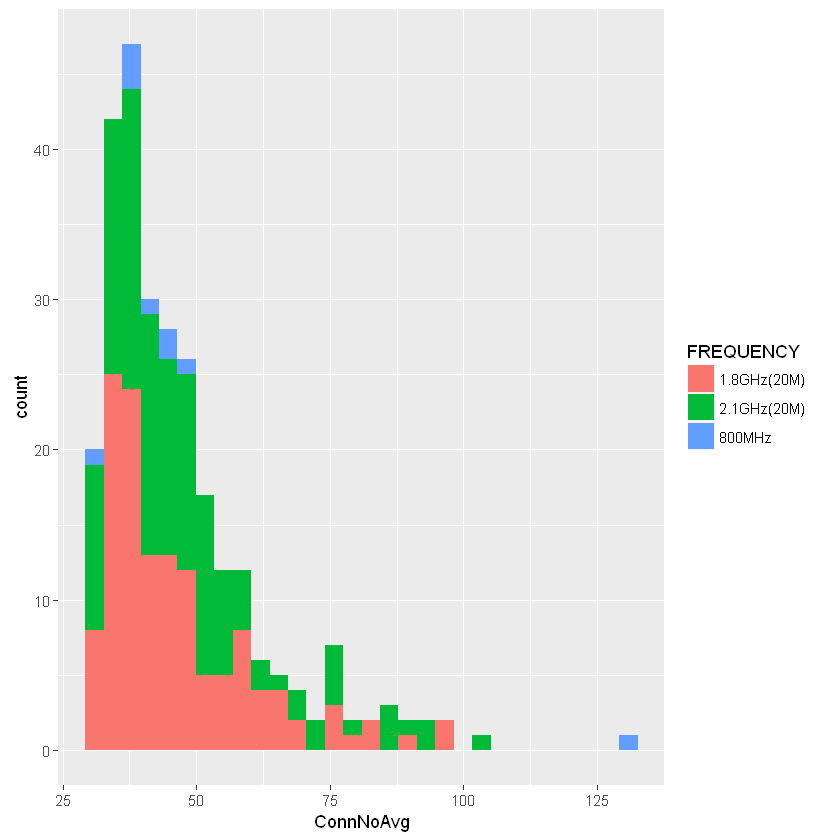

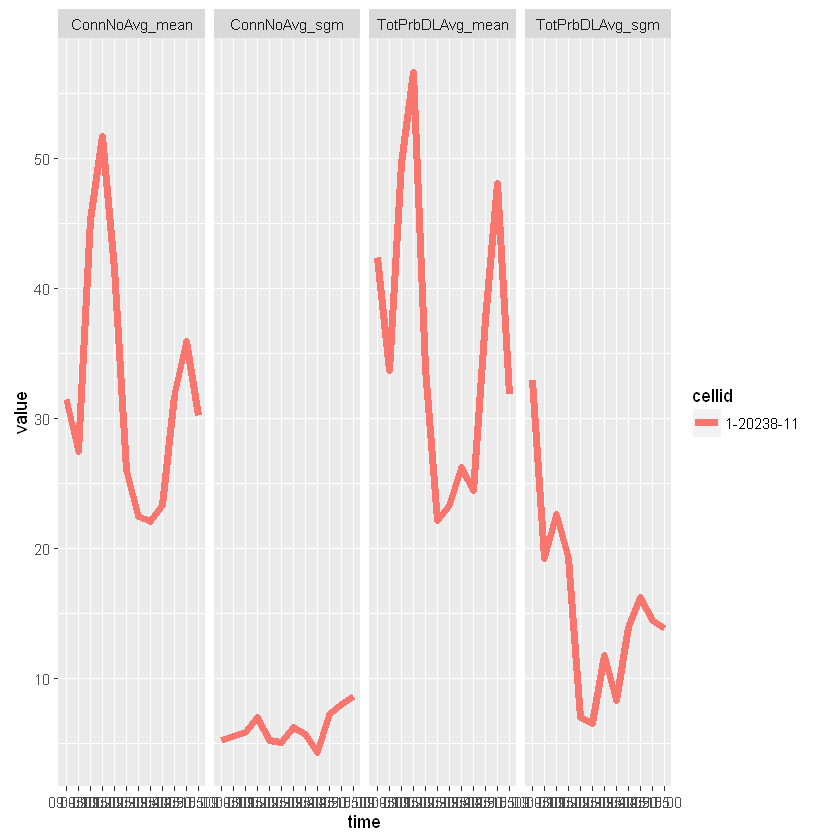

In [25]:
######800MHz ###################

hist(groupCONN9$ConnNoAvg)

# cellList is to be chosen for the range... make func...later...
cellList <- groupCONN9[groupCONN9$FREQUENCY=="800MHz", ]$cellid
#cellList <- groupCONN9$cellid

ggplot(groupCONN9, aes(ConnNoAvg, fill=FREQUENCY)) + geom_histogram()

sgm <- function(x){
        return(sqrt(var(x)))
}

stocavg.gr <-combind5M %>% filter(cellid %in% cellList) %>%  
        group_by(cellid,time) %>% 
        summarise_each(funs(mean,sgm), matches("Avg"))%>% 
        gather(key, value,-c(1,2))
# ggplot(stocavg.gr, aes(time,value,color=cellid, group=cellid)) + 
#         geom_line(size=2) + facet_wrap(~key, ncol=4)

stocavg <- stocavg.gr %>% spread(key, value) %>% 
        group_by(cellid) %>% summarise_each(funs(mean,sgm),matches("Avg")) %>% 
        select(cellid, ConnNoAvg_mean_sgm, ConnNoAvg_sgm_mean)        

# Find ConnNoAvg_mean_sigma high, ConnNoAvg_sgm_mean low  Cell....
stocavg.1 <-stocavg %>% 
        mutate(cellFeature=ConnNoAvg_mean_sgm/ConnNoAvg_sgm_mean) %>% 
        arrange(-cellFeature)

cellList.1 <- stocavg.1 %>% filter(cellFeature > 1.0) %>% select(cellid)
# this is the group which i may want to select....
cellList.1 <- cellList.1$cellid
stocavg.gr.1 <-combind5M %>% filter(cellid %in% cellList.1) %>%  
        group_by(cellid,time) %>% 
        summarise_each(funs(mean,sgm), matches("Avg"))%>% 
        gather(key, value,-c(1,2))
ggplot(stocavg.gr.1, aes(time,value,color=cellid, group=cellid)) + 
        geom_line(size=2) + facet_wrap(~key, ncol=4)

#HOW TO FIND MEAN SEQ IS NOT EVEN, DAILY VARIANCE SMALL 
# KEY FACTOR : FINDING THE DIFFERENCE IN ADJACENT CELLS...